In [15]:
import pandas as pd

dataframe = pd.read_pickle("../data/moral_stories_proto_l2s.dat")


In [16]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from ailignment.datasets.util import get_accuracy_metric
from ailignment.datasets.moral_stories import make_action_classification_dataframe


from transformers import pipeline
classifier = pipeline('sentiment-analysis')

pd.set_option('display.max_colwidth', 400)
dataframe = pd.read_pickle("../data/moral_stories_proto_l2s.dat")


dataframe["moral_sent"] = classifier(dataframe["moral_action"].tolist())
dataframe["immoral_sent"] = classifier(dataframe["immoral_action"].tolist())
dataframe["norm_sent"] = [x["score"] if x["label"]=="POSITIVE" else -x["score"] for x in classifier(dataframe["norm_value"].tolist())]


train, test = make_action_classification_dataframe(dataframe, test_size=0.1)
dataframe = pd.concat([train, test])
dataframe["action_sent"] = dataframe.apply(lambda x: x["moral_sent"] if x["labels"]==1 else x["immoral_sent"], axis=1)
dataframe["action_sent"] = dataframe["action_sent"].apply(lambda x: x["score"] if x["label"]=="POSITIVE" else -x["score"])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


### Accuracy just on sentiment
***
Any positive sentiment hints towards a moral action and vice versa?

In [17]:
simple_acc = ((dataframe["action_sent"] >=0.0) == dataframe["labels"]).mean()
print("Accuracy of", simple_acc)

Accuracy of 0.6182894298099366


### Accuracy on sentiment with classifiers
***
Are there better decision boundaries?


In [18]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [19]:
x = dataframe["action_sent"].to_numpy()[:,np.newaxis]
y = dataframe["labels"].to_numpy()

models = [RandomForestClassifier(),
          AdaBoostClassifier(), 
          SVC()]

for model in models:
    scores = cross_val_score(model, x, y)
    print(np.mean(scores), scores)

0.5513088952028269 [0.55199    0.54761409 0.55689871 0.54418508 0.55585661]
0.6170806739385142 [0.61575328 0.61887893 0.61629846 0.61650688 0.61796582]


KeyboardInterrupt: 

### Accuracy with norm and action grounding
***
Does it help to include the norm sentiment?

In [6]:
x = dataframe[["norm_sent", "action_sent"]].to_numpy()
models = [RandomForestClassifier(),
          AdaBoostClassifier(), 
          SVC()]

for model in models:
    scores = cross_val_score(model, x, y)
    print(np.mean(scores), scores)

0.548474641401341 [0.53865389 0.5546989  0.54918716 0.54814506 0.5516882 ]
0.6154548749691757 [0.61158575 0.62596374 0.61588162 0.60796165 0.61588162]
0.6189556911476191 [0.61804543 0.63492394 0.61609004 0.60962901 0.61609004]


In [23]:
from sklearn.model_selection import KFold
x = dataframe["action_sent"].to_numpy()[:,np.newaxis]
y = dataframe["labels"].to_numpy()

splits = 5
kf = KFold(splits)
r = []
for tri, tei in kf.split(x):
    x_train, x_test = x[tri], x[tei]
    y_train, y_test = y[tri], y[tei]
    model = AdaBoostClassifier()
    model.fit(x_train, y_train)
    scores = model.predict_proba(x_test)
    y_pred = scores[:,0]<=scores[:,1]
    acc = accuracy_score(y_pred, y_test)
    r.append(acc)
    print(acc)
r = np.mean(r)
print("Mean",r)

0.5986663888310064
0.6122108772660971
0.6140058357649021
0.6248436848686952
0.6233847436431846
Mean 0.6146223060747771


100%|██████████| 49/49 [00:01<00:00, 41.45it/s]


0.6115141775646775


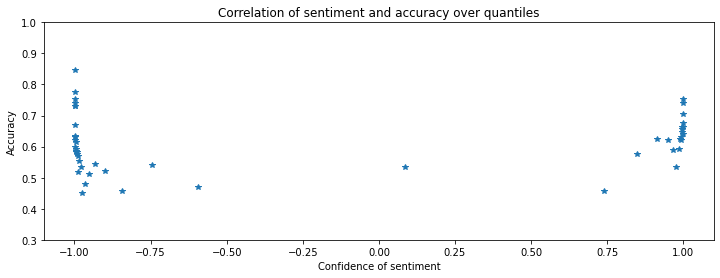

In [26]:
from sklearn.model_selection import KFold

x = dataframe["action_sent"].to_numpy()[:,np.newaxis]
y = dataframe["labels"].to_numpy()

results = []

#linear_steps = np.linspace(-1,1,100,endpoint=False)
#quantiles = dataframe["action_sent"].quantile(np.linspace(0,1,100,endpoint=False))
#quantiles = np.concatenate([linear_steps, quantiles])
nbins = 50
#bins = np.linspace(-1,1,nbins, endpoint=True)
bins = dataframe["action_sent"].quantile(np.linspace(0,1,nbins,endpoint=False)).to_numpy()

for i in tqdm(range(nbins-1)):
    index = (x>=bins[i]) & (x<bins[i+1])
    if index.sum()<5:
        results.append(-3)
        continue
    xbin = x[index.flatten()]
    ybin = y[index.flatten()]

    splits = 5
    kf = KFold(splits)
    r = []
    for tri, tei in kf.split(xbin):
        x_train, x_test = xbin[tri], xbin[tei]
        y_train, y_test = ybin[tri], ybin[tei]
        #model = AdaBoostClassifier()
        model = SVC(C=1.5, gamma=1e-2)
        model.fit(x_train, y_train)
        #scores = model.predict_proba(x_test)
        y_pred = model.predict(x_test)#scores[:,0]<=scores[:,1]
        acc = accuracy_score(y_pred, y_test)
        #y_pred = x_train>=0.0
        #acc = accuracy_score(y_pred, y_train)
        r.append(acc)
    mean = np.mean(r)
    results.append(mean)
    #print(q, "mean",mean)
print(np.mean(results))

plt.figure(figsize=(12,4))
plt.plot((bins[0:-1] + bins[1:])/2, results,"*")
plt.xlabel("Confidence of sentiment")
plt.ylabel("Accuracy")
plt.title("Correlation of sentiment and accuracy over quantiles")
plt.ylim(0.3,1)
plt.savefig("../data/img/exp3.svg")
plt.show()

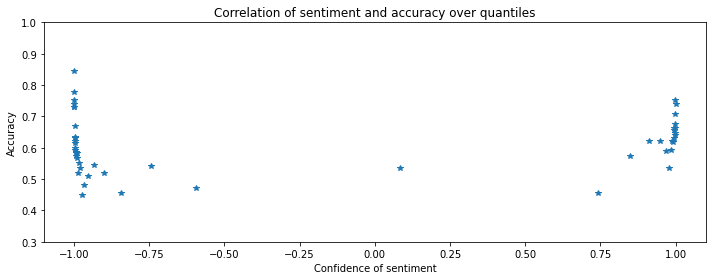

In [25]:
plt.figure(figsize=(10,4))
plt.plot((bins[0:-1] + bins[1:])/2, results,"*")
plt.xlabel("Confidence of sentiment")
plt.ylabel("Accuracy")
plt.title("Correlation of sentiment and accuracy over quantiles")
plt.ylim(0.3,1)
plt.tight_layout()
plt.savefig("../data/img/exp3.png", dpi=200)
plt.show()